In [1]:
import os
from pydap.client import open_url
import xarray as xr
import datetime
from datetime import timedelta, date
import netCDF4 as nc
from netCDF4 import Dataset
import os
import sys
sys.path.append(os.path.abspath(".."))
from utils.degree_day_equations import *
from utils.net_cdf_functions import *
from utils.processing_functions import *
#from utils.visualization_functions import *

import pandas as pd
#from visualization_functions import *
import numpy as np
data_path =  "../data/"

In [5]:
data 

NameError: name 'utils' is not defined

In [2]:

def mod_1_cumsum(data, start, threshold):
    #initialize variables
    cumsum = 0
    elapsed_days = 0
    #iterate through the data array starting from the given start position
    for i in range(start, len(data)):
        #add the value of the current position to the cumsum
        cumsum += data[i]
        #increment the elapsed days
        elapsed_days += 1
        #if the cumsum is greater than or equal to the threshold, return the number of elapsed days
        if cumsum >= threshold:
            return elapsed_days
    #if the end of the array is reached, start over from the beginning and keep counting
    for i in range(0, start):
        cumsum += data[i]
        elapsed_days += 1
        if cumsum >= threshold:
            return elapsed_days
    return elapsed_days
# Define points and locations
points = [
    (34.05, -118.25),  # Los Angeles
    (36.631151, -119.338321),  # Orange Cove, CA
    #(26.229485, -98.110049),  # McAllen, TX
    #(27.267190, -81.624871),  # Arcadia, FL
]
locations = ["Los Angeles" ,"Orange Cove, CA"]#, "McAllen, TX", "Arcadia, FL"]

# Fly species and thresholds
flies = {
    "mexfly": {"UTT": 999, "LTT": 9.4, "dd_threshold": 754},
    "orientalfruitfly": {"UTT": 999, "LTT": 8.375, "dd_threshold": 625},
    #"medfly": {"UTT": 999, "LTT": 12.44, "dd_threshold": 346},
}

# Initialize dictionary to store final dataframes
final_dfs = {}

# Loop through each fly species

for fly, params in flies.items():
    UTT = params["UTT"]
    LTT = params["LTT"]
    dd_threshold = params["dd_threshold"]
    print("loading data for " + fly)
    combined_dd_data = read_netcdfs(
        files=data_path + "PRISM/*/PRISM_temp_*.nc", points=points, LTT=LTT, UTT=UTT
    )

    
    # Initialize a nested dictionary for each fly species
    final_dfs[fly] = {}

    # Loop through each location
    for point, location in zip(points, locations):
        print("calculating results for " + fly + " in " + location)


        #model 1 data
        mod_1_dd_data = combined_dd_data.sel(point=locations.index(location))
        mod_1_dd_data['day_of_year'] = mod_1_dd_data.indexes['t'].dayofyear
        mod_1_data = mod_1_dd_data.groupby('day_of_year').mean('t')
        mod_1_data_dd = mod_1_data['degree_days'].values
        
        #model 2 data
        mod_2_data = combined_dd_data.sel(point=locations.index(location))
        
        mod_2_raw = []
        mod_2_mean = []
        mod_2_std = []
        mod_2_median = []
        mod_2_max = []
        mod_2_min = []
        mod_2_range = []

        # Model 1 calculations
        results = []
  
        for i in range(0, 366):
            results.append(mod_1_cumsum(mod_1_data_dd, i, dd_threshold * 3))
        results_df = pd.DataFrame(results)
        results_df.columns = ["days_to_threshold_mod_1"]
        results_df["day_of_year"] = range(1, 367)
        results_df["date"] = pd.to_datetime(results_df["day_of_year"], format="%j")
        results_df["date"] = results_df["date"].dt.strftime("%m-%d")
        results_df["date"] = "2020-" + results_df["date"]


        mod_2_max_year = []
        mod_2_min_year = []

        # Model 2 calculations
        for i in range(0, 366):
            date = "2023-" + str(i + 1).zfill(3)
            date = pd.to_datetime(date, format="%Y-%j")
            date = date.strftime("%Y-%m-%d")
            data = fflies_model_run(
                date,
                mod_2_data["degree_days"],
                point[0],
                point[1],
                LTT=LTT,
                UTT=UTT,
                dd_threshold=dd_threshold,
                use_current_years_weather=False,
            )
            data = data["timedelta"].values.tolist()
            mod_2_raw.append(data)
            mod_2_mean.append(np.mean(data))
            mod_2_std.append(np.std(data))
            mod_2_median.append(np.median(data))
            mod_2_max.append(np.max(data))
            mod_2_min.append(np.min(data))
            mod_2_range.append(np.max(data) - np.min(data))
            
            # Find the year for max and min values
            max_year = mod_2_data["degree_days"].t[np.argmax(data)].dt.year.item()
            min_year = mod_2_data["degree_days"].t[np.argmin(data)].dt.year.item()
            mod_2_max_year.append(max_year)
            mod_2_min_year.append(min_year)

        results_df["mod_2_raw"] = mod_2_raw
        results_df["mod_2_mean"] = mod_2_mean
        results_df["mod_2_std"] = mod_2_std
        results_df["mod_2_median"] = mod_2_median
        results_df["mod_2_max"] = mod_2_max
        results_df["mod_2_min"] = mod_2_min
        results_df["mod_2_range"] = mod_2_range
        results_df["mod_2_max_year"] = mod_2_max_year
        results_df["mod_2_min_year"] = mod_2_min_year

        final_dfs[fly][location] = results_df
# final_dfs now contains the dataframes for each fly species and location

loading data for mexfly
calculating results for mexfly in Los Angeles


c:\Users\Thomas.Worm\AppData\Local\anaconda3\envs\fruitflypheno\Lib\site-packages\xarray\core\dataset.py:4802: UserWarning: No index created for dimension day_of_year because variable day_of_year is not a coordinate. To create an index for day_of_year, please first call `.set_coords('day_of_year')` on this object.
  warnings.warn(


running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 

c:\Users\Thomas.Worm\AppData\Local\anaconda3\envs\fruitflypheno\Lib\site-packages\xarray\core\dataset.py:4802: UserWarning: No index created for dimension day_of_year because variable day_of_year is not a coordinate. To create an index for day_of_year, please first call `.set_coords('day_of_year')` on this object.
  warnings.warn(


running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 

c:\Users\Thomas.Worm\AppData\Local\anaconda3\envs\fruitflypheno\Lib\site-packages\xarray\core\dataset.py:4802: UserWarning: No index created for dimension day_of_year because variable day_of_year is not a coordinate. To create an index for day_of_year, please first call `.set_coords('day_of_year')` on this object.
  warnings.warn(


running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 

c:\Users\Thomas.Worm\AppData\Local\anaconda3\envs\fruitflypheno\Lib\site-packages\xarray\core\dataset.py:4802: UserWarning: No index created for dimension day_of_year because variable day_of_year is not a coordinate. To create an index for day_of_year, please first call `.set_coords('day_of_year')` on this object.
  warnings.warn(


running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 20 yrs
running DD accumulations for historical data, 

In [38]:
#from final_dfs['mexfly']['Orange Cove, CA'] select where date is 2020-06-10
final_dfs['mexfly']['Orange Cove, CA'].loc[final_dfs['mexfly']['Orange Cove, CA']['date'] == '2020-06-10']


,days_to_threshold_mod_1,day_of_year,date,mod_2_raw,mod_2_mean,mod_2_std,mod_2_median,mod_2_max,mod_2_min,mod_2_range,mod_2_max_year,mod_2_min_year
160,189,161,2020-06-10,"[287, 203, 247, 154, 273, 229, 242, 273, 174, ...",210.1,48.651721,212.0,287,142,145,2000,2015


## below working on a plot of degree day accumulation for 2014 in orange grove ca starting June 1. 

In [2]:
points = [
    #(34.05, -118.25),  # Los Angeles
    (36.631151, -119.338321),  # Orange Cove, CA
    #(26.229485, -98.110049),  # McAllen, TX
    #(27.267190, -81.624871),  # Arcadia, FL
]
LTT = 9.4
UTT = 999
dd_threshold = 754

combined_dd_data = read_netcdfs(
        files=data_path + "PRISM/*/PRISM_temp_*.nc", points=points, LTT=LTT, UTT=UTT
    )

In [ ]:
latitude = 36.631151
longitude = -119.338321
window_size = 10

# Select a subset of data around the given coordinates
subset_da = results_da.sel(
    latitude=slice(latitude - window_size, latitude + window_size),
    longitude=slice(longitude - window_size, longitude + window_size)
)


NameError: name 'results_da' is not defined

: 

In [4]:
#make model_1 data
mod_1_dd_data = combined_dd_data
mod_1_dd_data['day_of_year'] = mod_1_dd_data.indexes['t'].dayofyear

mod_1_dd_data = mod_1_dd_data.set_coords('day_of_year')
mod_1_data = mod_1_dd_data.groupby('day_of_year').mean('t')
mod_1_data_dd = mod_1_data['degree_days'].values


Model 1 day: 255
Model 2 day: 299


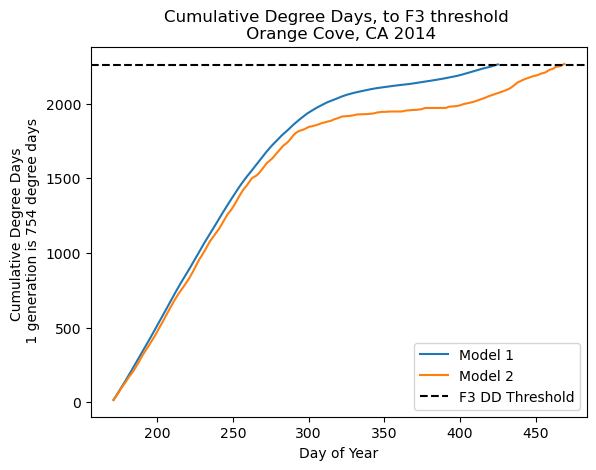

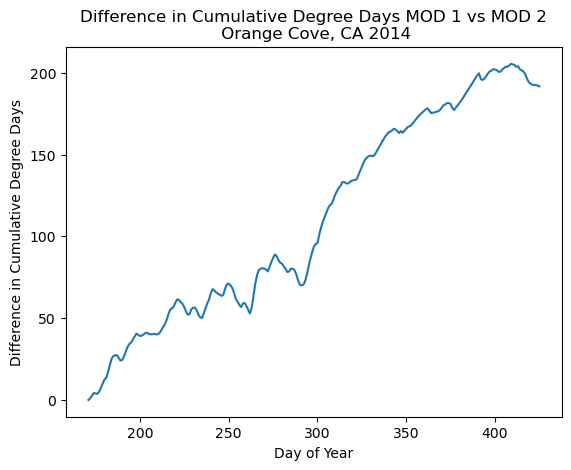

: 

In [ ]:
#starting on june 1th I want to iterate through the model_1 data and make a dataframe of the day of the year and the number of days to reach the threshold. Then compare to years 2020-2023
day_of_year = []
mod_1_cumsum_data = []
mod_2_cumsum_data = []

start_day = 171
cumsum_mod_1 = 0
cumsum_mod_2 = 0
for i in range(0, 366):
    #get degree days for the day
    day_of_year.append((i + start_day) )
    if cumsum_mod_1 < dd_threshold*3:
        try:
            cumsum_mod_1 += mod_1_data_dd[(i + start_day)%365 ][0]
        except:
            print(i + start_day)
        mod_1_cumsum_data.append(cumsum_mod_1)
    else: 
        mod_1_cumsum_data.append(None)
    if cumsum_mod_2 < dd_threshold*3:
        try:
            cumsum_mod_2 += combined_dd_data['degree_days'].isel(t=i + start_day + (365 * 4) ).values[0]
        except:
            print(i + start_day + (365*7))
        mod_2_cumsum_data.append(cumsum_mod_2)
    else:
        mod_2_cumsum_data.append(None)

#determine the day of the year that the threshold is reached for each model by finding the last index where cumsum is not nan
mod_1_day = len(mod_1_cumsum_data) - mod_1_cumsum_data[::-1].index(next(x for x in mod_1_cumsum_data[::-1] if x is not None))
mod_2_day = len(mod_2_cumsum_data) - mod_2_cumsum_data[::-1].index(next(x for x in mod_2_cumsum_data[::-1] if x is not None))

print("Model 1 day: " + str(mod_1_day)) 
print("Model 2 day: " + str(mod_2_day))

#make a dataframe
cumsum_df = pd.DataFrame()
cumsum_df['day_of_year'] = day_of_year
cumsum_df['mod_1_cumsum'] = mod_1_cumsum_data
cumsum_df['mod_2_cumsum'] = mod_2_cumsum_data
cumsum_df['diff'] = cumsum_df['mod_1_cumsum'] - cumsum_df['mod_2_cumsum']


#plot cumsum df
import matplotlib.pyplot as plt
plt.title("Cumulative Degree Days, to F3 threshold \n Orange Cove, CA 2014") 
plt.xlabel("Day of Year")
plt.ylabel("Cumulative Degree Days \n 1 generation is 754 degree days")
plt.plot(cumsum_df['day_of_year'], cumsum_df['mod_1_cumsum'])
plt.plot(cumsum_df['day_of_year'], cumsum_df['mod_2_cumsum'])
#add a horizontal line at 754*3
plt.axhline(y=754*3, color='black', linestyle='--')

plt.legend(['Model 1', 'Model 2', 'F3 DD Threshold'])

plt.show()


#plot diff data
import matplotlib.pyplot as plt

plt.plot(cumsum_df['day_of_year'], cumsum_df['diff'])
#xlabel and ylabel
plt.xlabel("Day of Year")
plt.ylabel("Difference in Cumulative Degree Days")
plt.title("Difference in Cumulative Degree Days MOD 1 vs MOD 2\n Orange Cove, CA 2014")
plt.show()


In [52]:
cumsum_df

,day_of_year,mod_1_cumsum,mod_2_cumsum,diff
0,171,14.831686,16.553499,-1.721813
1,172,30.283278,32.764499,-2.481221
2,173,46.313722,47.481999,-1.168277
3,174,62.599208,62.308500,0.290708
4,175,78.740340,77.833001,0.907339
...,...,...,...,...
361,532,NaN,NaN,NaN
362,533,NaN,NaN,NaN
363,534,NaN,NaN,NaN
364,535,NaN,NaN,NaN


In [21]:
combined_dd_data['degree_days'].isel(t=i + start_day + (365*7))

<xarray.DataArray 'degree_days' (point: 1)> Size: 8B
array([10.4324995])
Coordinates:
    t          datetime64[ns] 8B 2008-06-07
    longitude  float64 8B -119.3
    latitude   float64 8B 36.62
Dimensions without coordinates: point

In [56]:
i

365

In [55]:
combined_dd_data['degree_days'].isel(t=i + start_day )

<xarray.DataArray 'degree_days' (point: 1)> Size: 8B
array([17.10799942])
Coordinates:
    t          datetime64[ns] 8B 2001-06-20
    longitude  float64 8B -119.3
    latitude   float64 8B 36.62
Dimensions without coordinates: point

In [23]:
mod_1_data_dd[5]

array([1.48821677])

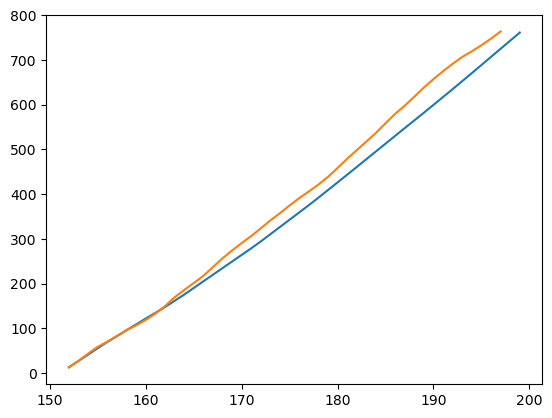

In [31]:
)


In [32]:
cumsum_df

,day_of_year,mod_1_cumsum,mod_2_cumsum
0,152,13.333597,12.7160
1,153,27.215740,27.3680
2,154,41.348982,43.6695
3,155,55.662206,58.8425
4,156,69.623698,70.4935
...,...,...,...
361,148,NaN,NaN
362,149,NaN,NaN
363,150,NaN,NaN
364,151,NaN,NaN


In [20]:
combined_dd_data['degree_days'].isel(t=5 + 20 + (365 * 14)).data[0]

3.6620960453349776

In [11]:
mod_1_dd_data = mod_1_data['degree_days'].values
#create a dataframe to store the results with the daily degree day and the day of year
results_df = pd.DataFrame()
results_df['day_of_year'] = range(1, 367)
results_df['degree_days'] = mod_1_dd_data
results_df['date'] = pd.to_datetime(results_df['day_of_year'], format='%j')
results_df['date'] = results_df['date'].dt.strftime('%m-%d')

###model 2
#for model 2, I want a column in results df for each year of data 2000-2023. give the daily degree days for each year as a column 
for i in range(2000, 2024):
    mod_2_data = combined_dd_data.sel(t = slice(f'{i}-01-01', f'{i}-12-31'))
    mod_2_data = mod_2_data['degree_days'].values[0]
    if len (mod_2_data) < 366:
        mod_2_data = np.append(mod_2_data, np.nan)
        
    results_df[f'{i}'] = mod_2_data


array([[ 1.1281478 ],
       [ 1.06343928],
       [ 1.22287753],
       [ 1.52349754],
       [ 1.65110259],
       [ 1.48821677],
       [ 1.43526062],
       [ 1.57861524],
       [ 1.67786548],
       [ 1.7987563 ],
       [ 1.61243633],
       [ 1.46416782],
       [ 1.50357484],
       [ 1.73324807],
       [ 1.28246078],
       [ 1.47731031],
       [ 1.5697954 ],
       [ 1.5354921 ],
       [ 1.74556411],
       [ 1.69166804],
       [ 1.79177113],
       [ 1.55905007],
       [ 1.76659142],
       [ 1.75556766],
       [ 1.81435355],
       [ 2.00840051],
       [ 1.98233402],
       [ 1.77255538],
       [ 1.79401468],
       [ 1.98962793],
       [ 2.00672651],
       [ 1.9930055 ],
       [ 2.26570771],
       [ 2.36826936],
       [ 2.53549358],
       [ 2.74201558],
       [ 2.73474198],
       [ 2.66092415],
       [ 2.82039069],
       [ 3.02866509],
       [ 3.0923237 ],
       [ 3.00930368],
       [ 2.71478988],
       [ 3.06211191],
       [ 3.3749046 ],
       [ 3

NameError: name 'final_dfs' is not defined

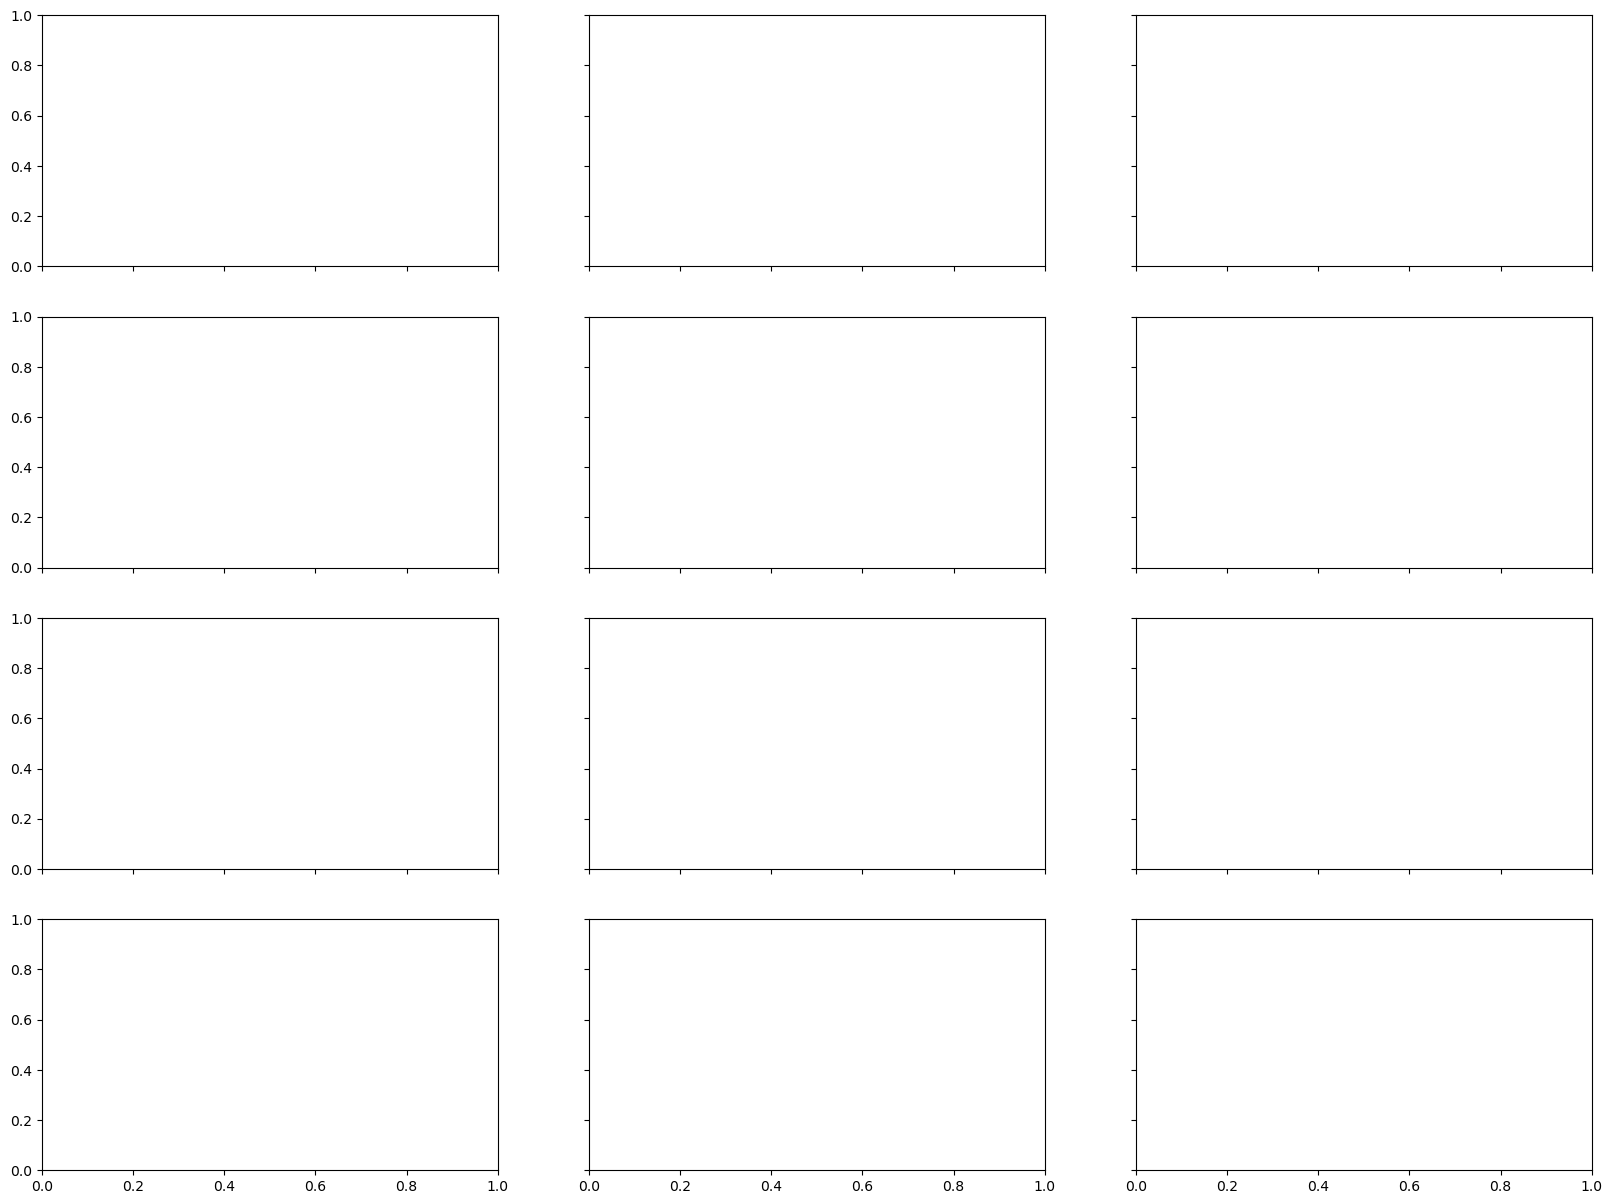

In [5]:

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt

# Number of flies and locations
num_flies = len(flies)
num_locations = len(locations)

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_locations, num_flies, figsize=(20, 15), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each location and fly species
for i, location in enumerate(locations):
    for j, fly in enumerate(flies.keys()):
        results_df = final_dfs[fly][location]
        ax = axes[i * num_flies + j]
        
        # Plot model 1 results
        ax.plot(results_df['days_to_threshold_mod_1'], color='red', label='model 1 - days to F3')
        cmap = plt.get_cmap('rainbow')
        norm = mcolors.Normalize(vmin=results_df['mod_2_min_year'].min(), vmax=results_df['mod_2_max_year'].max())

# Plot the fill_between with color representing the year
        for i in range(len(results_df)):
            ax.fill_between(
                [results_df['day_of_year'][i], results_df['day_of_year'][i]],
                results_df['mod_2_min'][i],
                results_df['mod_2_max'][i],
                color=cmap(norm(results_df['mod_2_max_year'][i])),
                alpha=0.5
            )

        ax.plot(results_df['day_of_year'], results_df['mod_2_mean'], color='blue', label='model 2 - mean days to F3 20 years')
        
        # Calculate the maximum difference between mod_2_max and mod_2_min
        max_diff = (results_df['mod_2_max'] - results_df['mod_2_min']).max()
        max_diff_day = (results_df['mod_2_max'] - results_df['mod_2_min']).idxmax()
        
        # Add a vertical line at the point of maximum difference
        ax.axvline(x=max_diff_day, color='green', linestyle='--', label=f'Max diff: {max_diff:.2f} days')
        
        # Annotate the maximum difference
        ax.annotate(f'{max_diff:.2f}', xy=(max_diff_day, results_df['mod_2_max'][max_diff_day]), 
                    xytext=(max_diff_day, results_df['mod_2_max'][max_diff_day] + 5),
                    arrowprops=dict(facecolor='black', shrink=0.05))
        
        # Set x-ticks and labels
        ax.set_xticks(range(0, 366, 31))
        ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        
        # Set title and labels
        ax.set_title(f'{fly}, {location}')
        ax.set_xlabel('Month')
        ax.set_ylabel('Days to Threshold')
        
        # Add legend
        ax.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

#plot the results with month labels
import matplotlib.pyplot as plt
#change plot size
plt.figure(figsize=(14, 6))

plt.plot(results_df['days_to_threshold_mod_1'], color = 'red', label='model 1 - days to F3')
#add mod_2 min and max and shade the area between them
plt.fill_between(results_df['day_of_year'], results_df['mod_2_min'], results_df['mod_2_max'], alpha=0.5, label='model 2 - min/max observed days to F3 20 years')
#add mod_2 mean in red  
plt.plot(results_df['day_of_year'], results_df['mod_2_mean'], color='blue', label='model 2 - mean days to F3 20 years ')

plt.xticks(range(0, 366, 31), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#add legend
plt.legend()

plt.xlabel('Month')
plt.ylabel('Days to Threshold')
plt.title('Days to complete F3, mexfly, Los Angeles')
plt.show()

#repeat as interactive plot and hover tool. save to html
from bokeh.plotting import figure, output_file, show
from bokeh.models import HoverTool
from bokeh.io import output_notebook
output_notebook()


In [30]:
points = [
    (34.05, -118.25),  # Los Angeles
    (36.631151, -119.338321),  # Orange Cove, CA
    (26.229485, -98.110049),  # McAllen, TX
    (27.267190, -81.624871),  # Arcadia, FL
]
locations = ["Los Angeles", "Orange Cove, CA", "McAllen, TX", "Arcadia, FL"]

# Fly species and thresholds
flies = {
    "mexfly": {"UTT": 999, "LTT": 9.4, "dd_threshold": 754},
    "orientalfruitfly": {"UTT": 999, "LTT": 8.375, "dd_threshold": 625},
    "medfly": {"UTT": 999, "LTT": 12.44, "dd_threshold": 346},
}


In [31]:
final_dfs['mexfly']

NameError: name 'final_dfs' is not defined

NameError: name 'final_dfs' is not defined

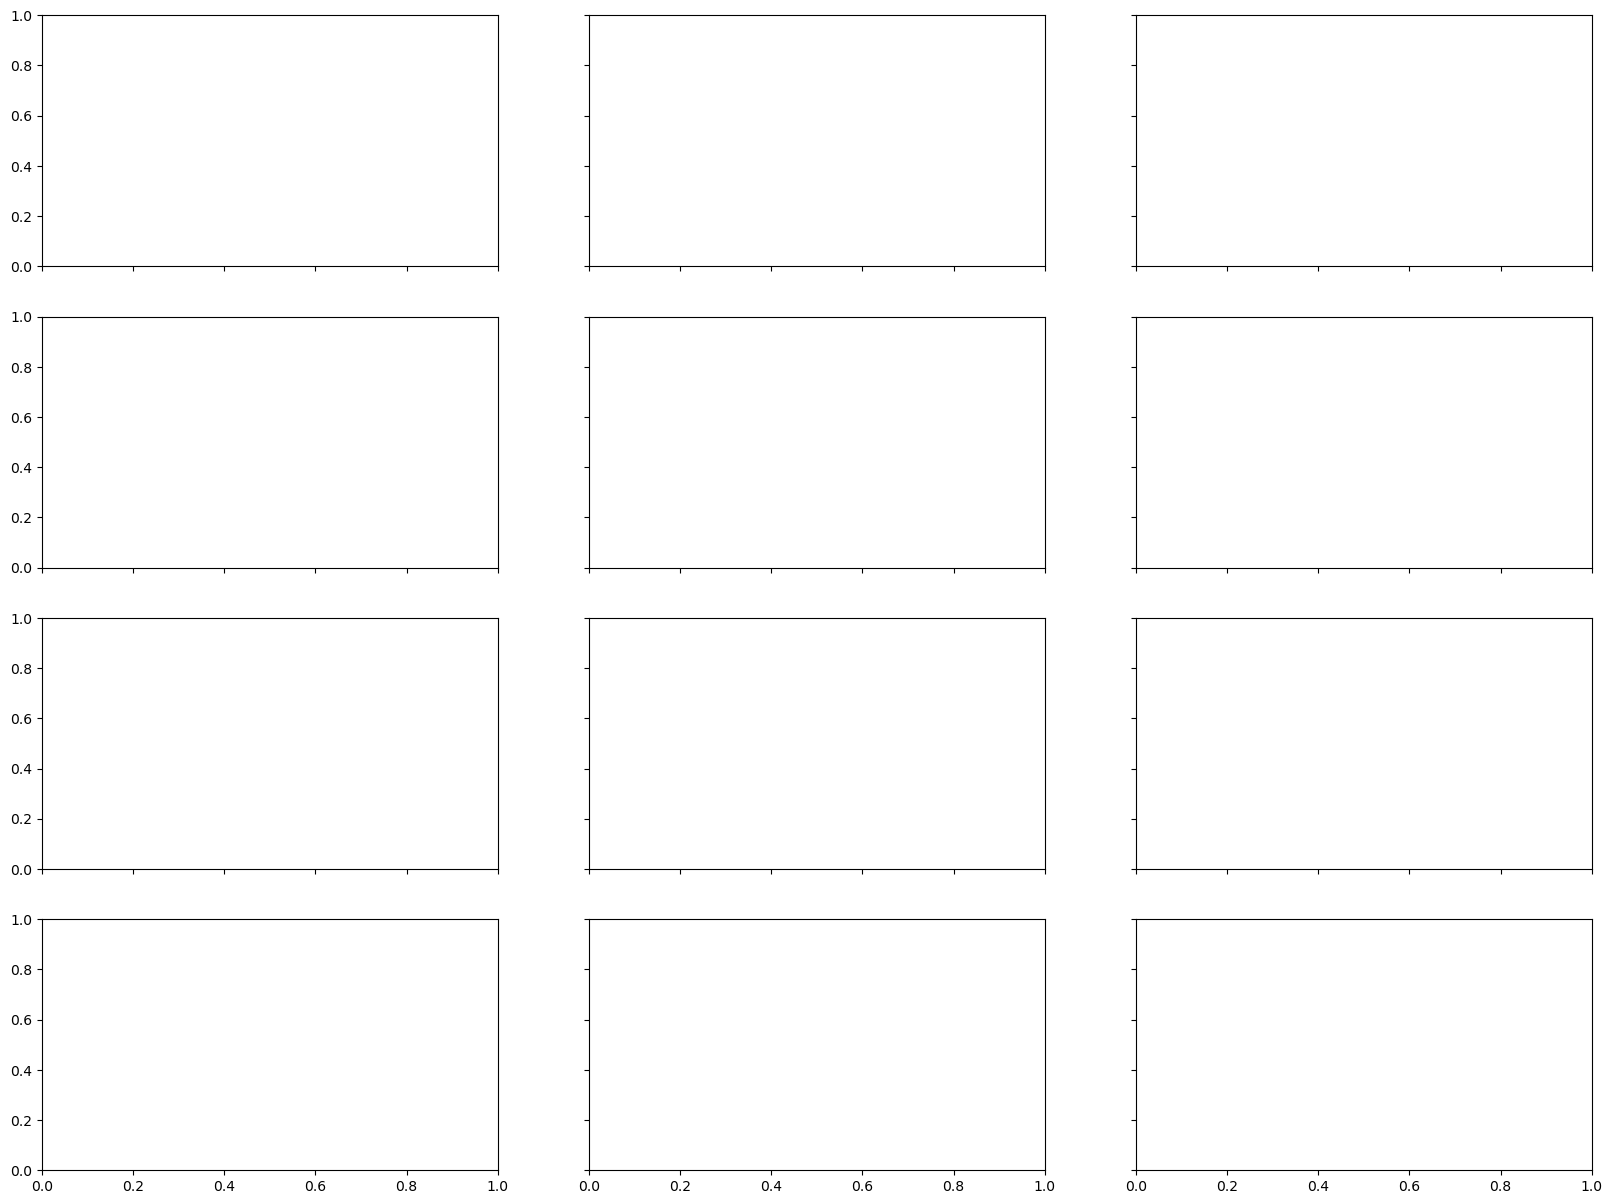

In [33]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

num_flies = len(flies)
num_locations = len(locations)

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_locations, num_flies, figsize=(20, 15), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()
palette = sns.color_palette("husl", 25)

# Create a colormap with the generated colors

# Loop through each location and fly species
for i, location in enumerate(locations):
    for j, fly in enumerate(flies.keys()):
        results_df = final_dfs[fly][location]
        #results_df[mod_2_max_year] = GET INDEX OF MAX VALUE IN MOD_2_RAW AND ADD 2000
        results_df['mod_2_max_year'] = results_df['mod_2_raw'].apply(lambda x: x.index(max(x)) + 2000)
        results_df['mod_2_min_year'] = results_df['mod_2_raw'].apply(lambda x: x.index(min(x)) + 2000)

        years = list(set(results_df['mod_2_max_year'].unique().tolist() + results_df['mod_2_min_year'].unique().tolist()))
        print(years)
        #order years
        years.sort()
        print(years)

        palette = sns.color_palette("tab20", len(years))

# Create a colormap with the generated colors
        cmap = mcolors.ListedColormap(palette)
        norm = mcolors.BoundaryNorm(boundaries=years, ncolors=len(palette))

        ax = axes[i * num_flies + j]
        
        # Plot model 1 results
        ax.plot(results_df['days_to_threshold_mod_1'], color='red', label='model 1 - days to F3')
        
        # Plot model 2 results

        years = np.arange(2000, 2025)
        

# Plot the fill_bet
# Plot the fill_between with color representing the year
        
        for f in range(len(results_df) - 1):
            ax.fill_between(
                [results_df['day_of_year'][f], results_df['day_of_year'][f+1]],
                results_df['mod_2_mean'][f],
                results_df['mod_2_max'][f],
                color=cmap(norm(results_df['mod_2_max_year'][f])),
                alpha=1
        )

        
        for f in range(len(results_df) - 1):
            ax.fill_between(
                [results_df['day_of_year'][f], results_df['day_of_year'][f+1]],
                results_df['mod_2_mean'][f],
                results_df['mod_2_min'][f],
                color=cmap(norm(results_df['mod_2_min_year'][f])),
                alpha=1
        )
        
        #ax.fill_between(results_df['day_of_year'], results_df['mod_2_min'], results_df['mod_2_max'], alpha=0.5, label='model 2 - min/max observed days to F3 20 years')
        ax.plot(results_df['day_of_year'], results_df['mod_2_mean'], color='blue', label='model 2 - mean days to F3 20 years')
        
        # Calculate the maximum difference between mod_2_max and mod_2_min
        max_diff = (results_df['mod_2_max'] - results_df['mod_2_min']).max()
        max_diff_day = (results_df['mod_2_max'] - results_df['mod_2_min']).idxmax()
        
        # Add a vertical line at the point of maximum difference
        ax.axvline(x=max_diff_day, color='green', linestyle='--', label=f'Max diff: {max_diff:.2f} days')
        
        # Annotate the maximum difference
        ax.annotate(f'{max_diff:.2f}', xy=(max_diff_day, results_df['mod_2_max'][max_diff_day]), 
                    xytext=(max_diff_day, results_df['mod_2_max'][max_diff_day] + 5),
                    arrowprops=dict(facecolor='black', shrink=0.05))
        
        # Set x-ticks and labels
        ax.set_xticks(range(0, 366, 31))
        ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        
        # Set title and labels
        ax.set_title(f'{fly}, {location}')
        ax.set_xlabel('Month')
        ax.set_ylabel('Days to Threshold')
        
        # Add legend
        ax.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

#plot the results with month labels
import matplotlib.pyplot as plt
#change plot size
plt.figure(figsize=(14, 6))

plt.plot(results_df['days_to_threshold_mod_1'], color = 'red', label='model 1 - days to F3')
#add mod_2 min and max and shade the area between them
#plt.fill_between(results_df['day_of_year'], results_df['mod_2_min'], results_df['mod_2_max'], alpha=0.5, label='model 2 - min/max observed days to F3 20 years')
#add mod_2 mean in red  
plt.plot(results_df['day_of_year'], results_df['mod_2_mean'], color='blue', label='model 2 - mean days to F3 20 years ')

plt.xticks(range(0, 366, 31), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#add legend
plt.legend()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, boundaries=np.arange(2000, 2026), ticks=np.arange(2000, 2025))
cbar.set_label('Year of Max Observation')
plt.xlabel('Month')
plt.ylabel('Days to Threshold')
plt.title('Days to complete F3, mexfly, Los Angeles')
plt.show()


In [73]:
years

In [80]:
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)]

In [28]:
# Print the original and normalized values
for year in range(2000, 2025):
    normalized_value = norm(year)
    color = cmap(normalized_value)
    print(f"Year: {year}, Normalized: {normalized_value}, Color: {color}")


Year: 2000, Normalized: 0, Color: (0.9019607843137255, 0.09803921568627451, 0.29411764705882354, 1.0)
Year: 2001, Normalized: 1, Color: (0.23529411764705882, 0.7058823529411765, 0.29411764705882354, 1.0)
Year: 2002, Normalized: 2, Color: (1.0, 0.8823529411764706, 0.09803921568627451, 1.0)
Year: 2003, Normalized: 3, Color: (0.2627450980392157, 0.38823529411764707, 0.8470588235294118, 1.0)
Year: 2004, Normalized: 4, Color: (0.9607843137254902, 0.5098039215686274, 0.19215686274509805, 1.0)
Year: 2005, Normalized: 5, Color: (0.5686274509803921, 0.11764705882352941, 0.7058823529411765, 1.0)
Year: 2006, Normalized: 6, Color: (0.27450980392156865, 0.9411764705882353, 0.9411764705882353, 1.0)
Year: 2007, Normalized: 7, Color: (0.9411764705882353, 0.19607843137254902, 0.9019607843137255, 1.0)
Year: 2008, Normalized: 8, Color: (0.7372549019607844, 0.9647058823529412, 0.047058823529411764, 1.0)
Year: 2009, Normalized: 9, Color: (0.9803921568627451, 0.7450980392156863, 0.7450980392156863, 1.0)
Yea

In [29]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define 20 distinct colors
colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
    '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
    '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
    '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080'
]

# Create a colormap with the defined colors
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=np.arange(2000, 2026), ncolors=len(colors))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 2))

# Plot the color mapping
for year in range(2000, 2025):
    normalized_value = norm(year)
    color = cmap(normalized_value)
    ax.plot([year, year], [0, 1], color=color, linewidth=10)

# Set the x-axis to show the years
ax.set_xticks(np.arange(2000, 2025))
ax.set_yticks([])  # Hide the y-axis

# Set labels and title
ax.set_xlabel('Year')
ax.set_title('Year to Color Mapping')

plt.show()

ValueError: There are 25 color bins including extensions, but ncolors = 20; ncolors must equal or exceed the number of bins

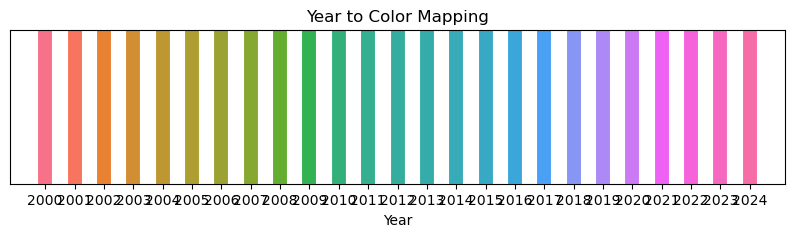

In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define 20 distinct colors
palette = sns.color_palette("husl", 25)

# Create a colormap with the generated colors
cmap = mcolors.ListedColormap(palette)
norm = mcolors.BoundaryNorm(boundaries=np.arange(2000, 2026), ncolors=len(palette))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 2))

# Plot the color mapping
for year in range(2000, 2025):
    normalized_value = norm(year)
    color = cmap(normalized_value)
    ax.plot([year, year], [0, 1], color=color, linewidth=10)

# Set the x-axis to show the years
ax.set_xticks(np.arange(2000, 2025))
ax.set_yticks([])  # Hide the y-axis

# Set labels and title
ax.set_xlabel('Year')
ax.set_title('Year to Color Mapping')

plt.show()

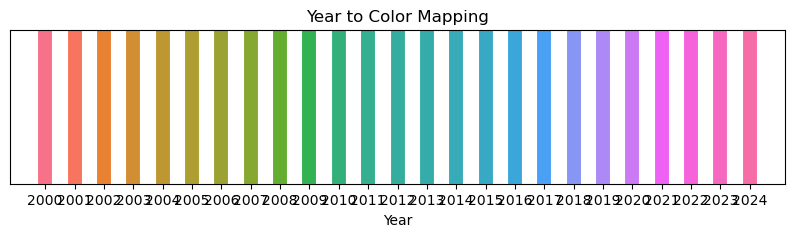

In [35]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns

# Generate a palette with 25 distinct colors using seaborn
palette = sns.color_palette("husl", 25)

# Create a colormap with the generated colors
cmap = mcolors.ListedColormap(palette)
norm = mcolors.BoundaryNorm(boundaries=np.arange(2000, 2026), ncolors=len(palette))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 2))

# Plot the color mapping
for year in range(2000, 2025):
    normalized_value = norm(year)
    color = cmap(normalized_value)
    ax.plot([year, year], [0, 1], color=color, linewidth=10)

# Set the x-axis to show the years
ax.set_xticks(np.arange(2000, 2025))
ax.set_yticks([])  # Hide the y-axis

# Set labels and title
ax.set_xlabel('Year')
ax.set_title('Year to Color Mapping')

plt.show()

c:\Users\Thomas.Worm\AppData\Local\anaconda3\envs\fruitflypheno\Lib\site-packages\xarray\core\dataset.py:4802: UserWarning: No index created for dimension day_of_year because variable day_of_year is not a coordinate. To create an index for day_of_year, please first call `.set_coords('day_of_year')` on this object.
  warnings.warn(


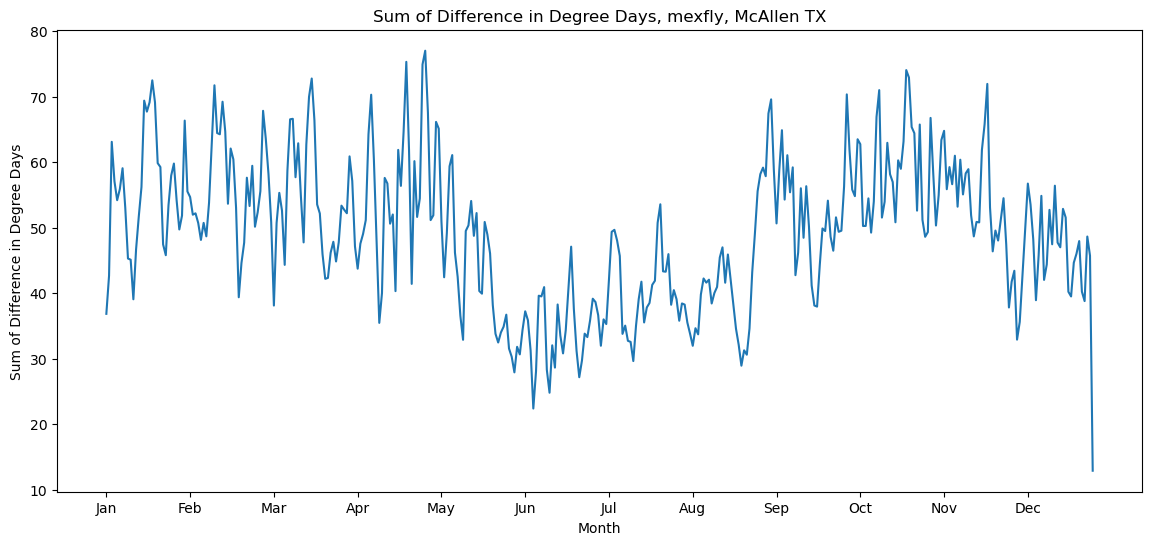

In [60]:
#testing a single site to see what time of year has greatest divergience between average and yearly
#site =  (36.631151, -119.338321), # Orange Cove, CA
#for mexfly
UTT = 999
LTT = 9.4
dd_threshold = 754
location = (26.229485, -98.110049)
data_path = "../data/"


'''
combined_dd_data = read_netcdfs(
        files=data_path + "PRISM/*/PRISM_temp_*.nc", points=[(26.229485, -98.110049)], LTT=LTT, UTT=UTT
    )
'''
    
    
#model 1 data
mod_1_dd_data = combined_dd_data

mod_1_dd_data['day_of_year'] = mod_1_dd_data.indexes['t'].dayofyear
mod_1_dd_data = mod_1_dd_data.groupby('day_of_year').mean('t')
mod_1_dd_data = mod_1_data['degree_days'].values
#create a dataframe to store the results with the daily degree day and the day of year
results_df = pd.DataFrame()
results_df['day_of_year'] = range(1, 367)
results_df['degree_days'] = mod_1_dd_data
results_df['date'] = pd.to_datetime(results_df['day_of_year'], format='%j')
results_df['date'] = results_df['date'].dt.strftime('%m-%d')

###model 2
#for model 2, I want a column in results df for each year of data 2000-2023. give the daily degree days for each year as a column 
for i in range(2000, 2024):
    mod_2_data = combined_dd_data.sel(t = slice(f'{i}-01-01', f'{i}-12-31'))
    mod_2_data = mod_2_data['degree_days'].values[0]
    if len (mod_2_data) < 366:
        mod_2_data = np.append(mod_2_data, np.nan)
        
    results_df[f'{i}'] = mod_2_data

for i in range(2000, 2024):
    results_df[f'{i}_diff'] = abs(results_df['degree_days'] - results_df[f'{i}'])
    
results_df['mean_diff'] = results_df.filter(like='_diff').mean(axis=1)
results_df['std_diff'] = results_df.filter(like='_diff').std(axis=1)
results_df['sum_diff'] = results_df.filter(like='_diff').sum(axis=1)
results_df['max_diff'] = results_df.filter(like='_diff').max(axis=1)
results_df
plt.figure(figsize=(14, 6))
plt.plot(results_df['max_diff'])
plt.xticks(range(0, 366, 31), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.ylabel('Sum of Difference in Degree Days')
plt.title('Sum of Difference in Degree Days, mexfly, McAllen TX')
plt.show()



c:\Users\Thomas.Worm\AppData\Local\anaconda3\envs\fruitflypheno\Lib\site-packages\xarray\core\dataset.py:4802: UserWarning: No index created for dimension day_of_year because variable day_of_year is not a coordinate. To create an index for day_of_year, please first call `.set_coords('day_of_year')` on this object.
  warnings.warn(


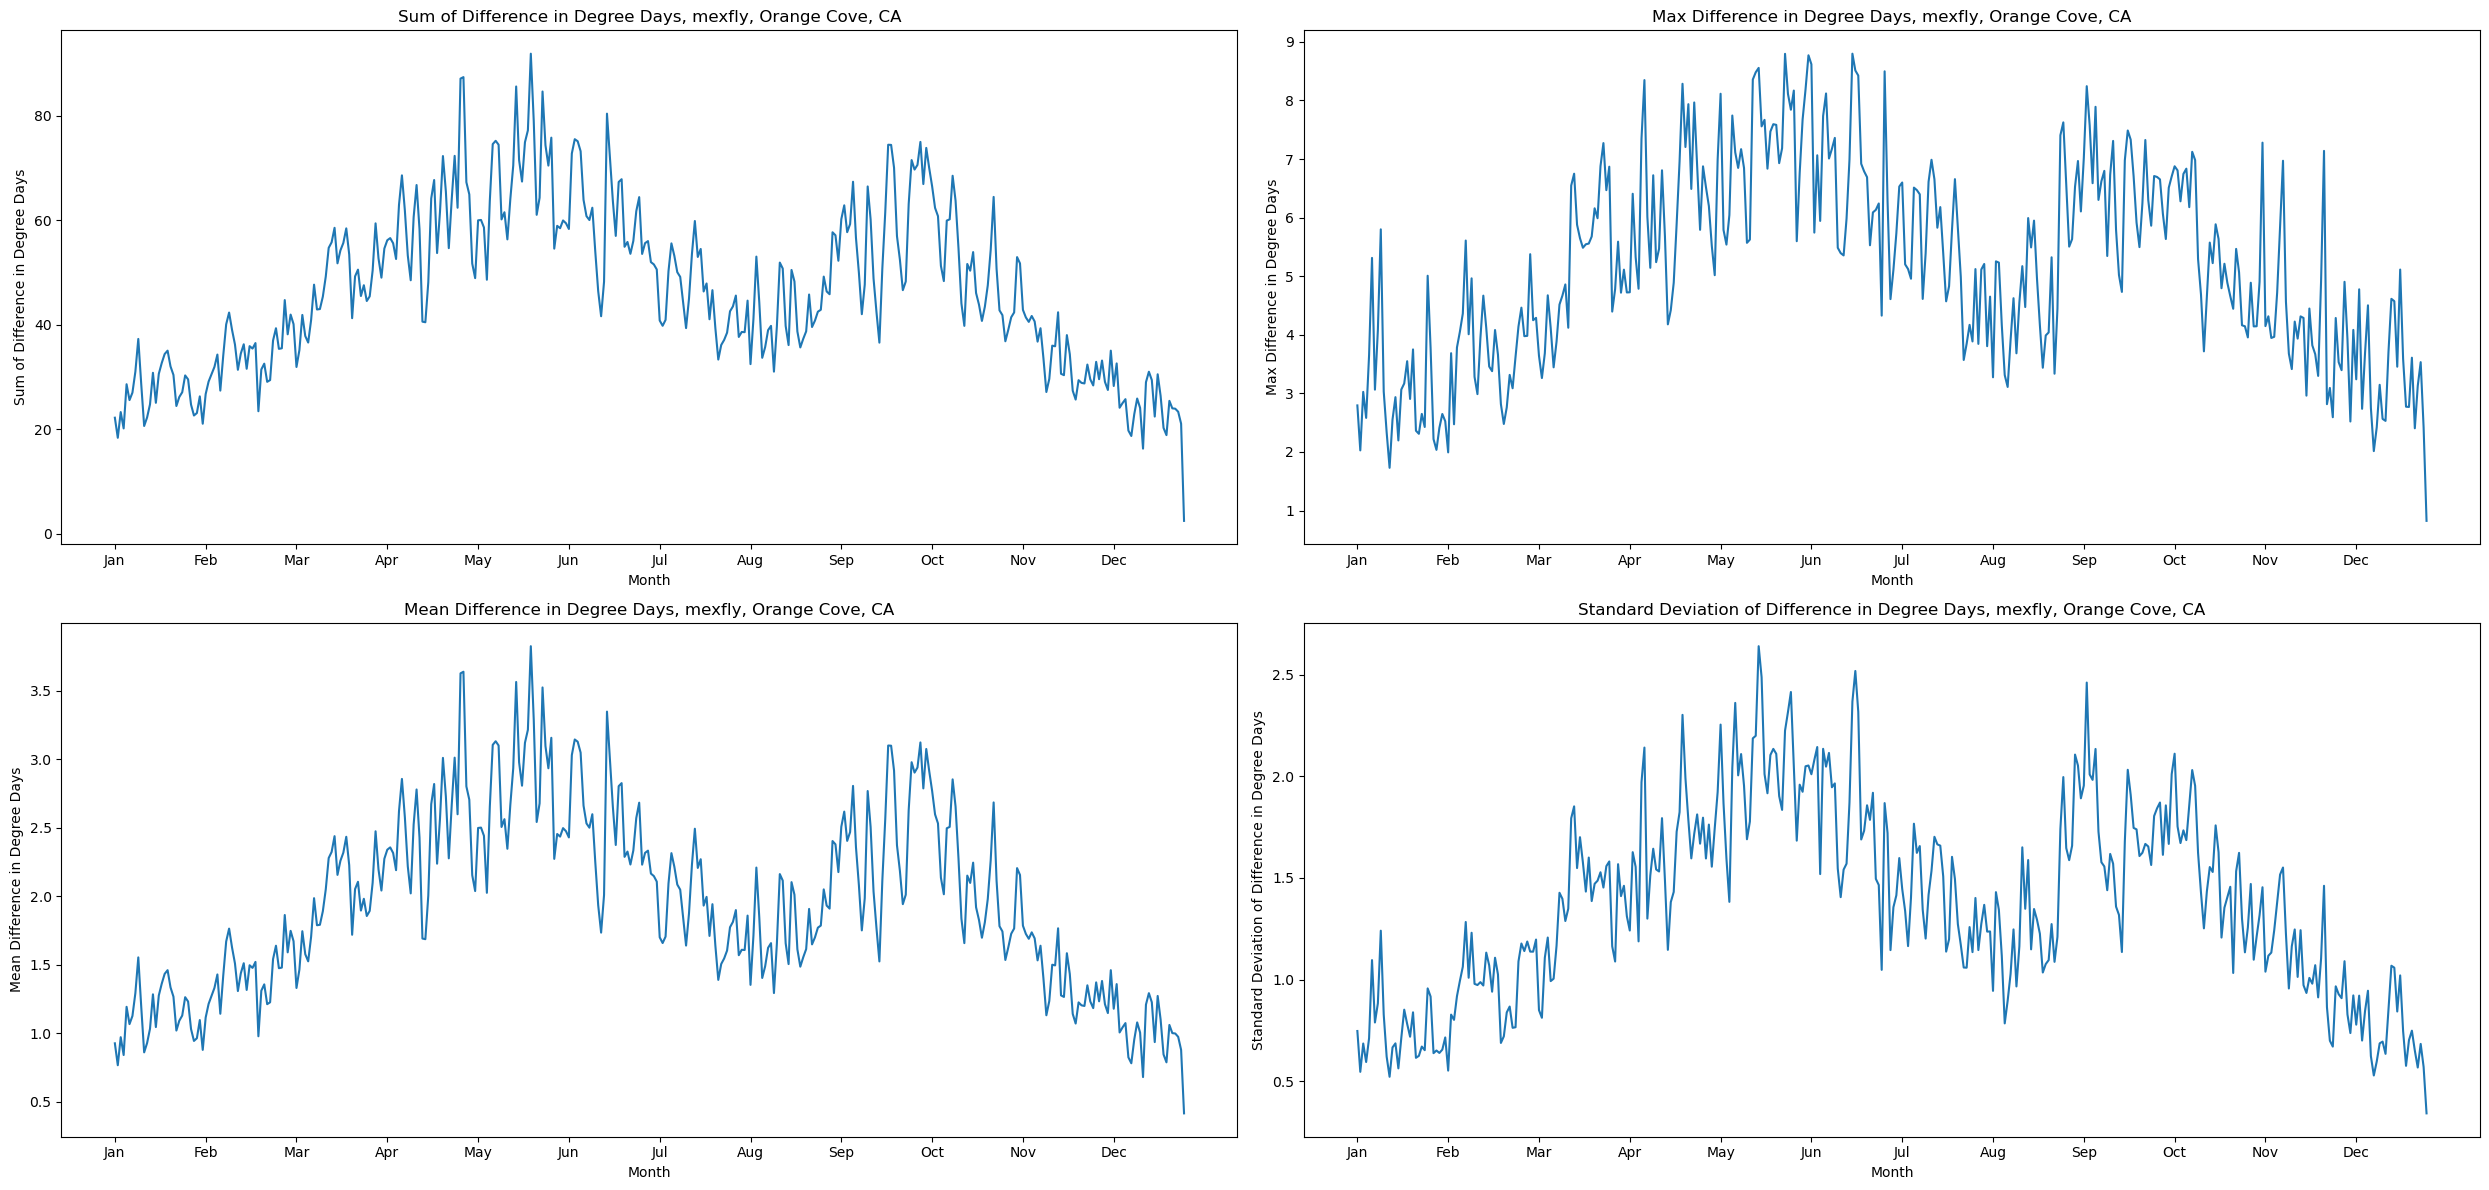

In [11]:
#testing a single site to see what time of year has greatest divergience between average and yearly
#site =  (36.631151, -119.338321), # Orange Cove, CA
#for mexfly
UTT = 999
LTT = 9.4
dd_threshold = 754
location = (36.631151, -119.338321)
data_path = "../data/"



combined_dd_data = read_netcdfs(
        files=data_path + "PRISM/*/PRISM_temp_*.nc", points=[(36.631151, -119.338321)], LTT=LTT, UTT=UTT
    )

    
    
#model 1 data
mod_1_dd_data = combined_dd_data

mod_1_dd_data['day_of_year'] = mod_1_dd_data.indexes['t'].dayofyear
mod_1_dd_data = mod_1_dd_data.groupby('day_of_year').mean('t')
mod_1_dd_data = mod_1_data['degree_days'].values
#create a dataframe to store the results with the daily degree day and the day of year
results_df = pd.DataFrame()
results_df['day_of_year'] = range(1, 367)
results_df['degree_days'] = mod_1_dd_data
results_df['date'] = pd.to_datetime(results_df['day_of_year'], format='%j')
results_df['date'] = results_df['date'].dt.strftime('%m-%d')

###model 2
#for model 2, I want a column in results df for each year of data 2000-2023. give the daily degree days for each year as a column 
for i in range(2000, 2024):
    mod_2_data = combined_dd_data.sel(t = slice(f'{i}-01-01', f'{i}-12-31'))
    mod_2_data = mod_2_data['degree_days'].values[0]
    if len (mod_2_data) < 366:
        mod_2_data = np.append(mod_2_data, np.nan)
        
    results_df[f'{i}'] = mod_2_data

for i in range(2000, 2024):
    results_df[f'{i}_diff'] = abs(results_df['degree_days'] - results_df[f'{i}'])
results_df['sum_dz'] = results_df.filter(like='_diff').sum(axis=1)

results_df['mean_dz'] = results_df.filter(like='_diff').mean(axis=1)
results_df['std_dz'] = results_df.filter(like='_diff').std(axis=1)
results_df['sum_dz'] = results_df.filter(like='_diff').sum(axis=1)
results_df['max_dz'] = results_df.filter(like='_diff').max(axis=1)
results_df

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(25, 12))

# Plot sum_diff
axs[0, 0].plot(results_df['sum_dz'])
axs[0, 0].set_xticks(range(0, 366, 31))
axs[0, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[0, 0].set_xlabel('Month')
axs[0, 0].set_ylabel('Sum of Difference in Degree Days')
axs[0, 0].set_title('Sum of Difference in Degree Days, mexfly, Orange Cove, CA')

# Plot max_diff
axs[0, 1].plot(results_df['max_dz'])
axs[0, 1].set_xticks(range(0, 366, 31))
axs[0, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[0, 1].set_xlabel('Month')
axs[0, 1].set_ylabel('Max Difference in Degree Days')
axs[0, 1].set_title('Max Difference in Degree Days, mexfly, Orange Cove, CA')

# Plot mean_diff
axs[1, 0].plot(results_df['mean_dz'])
axs[1, 0].set_xticks(range(0, 366, 31))
axs[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[1, 0].set_xlabel('Month')
axs[1, 0].set_ylabel('Mean Difference in Degree Days')
axs[1, 0].set_title('Mean Difference in Degree Days, mexfly, Orange Cove, CA')

# Plot std_diff
axs[1, 1].plot(results_df['std_dz'])
axs[1, 1].set_xticks(range(0, 366, 31))
axs[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[1, 1].set_xlabel('Month')
axs[1, 1].set_ylabel('Standard Deviation of Difference in Degree Days')
axs[1, 1].set_title('Standard Deviation of Difference in Degree Days, mexfly, Orange Cove, CA')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [34]:
results_df

,day_of_year,degree_days,date,2000,2001,2002,2003,2004,2005,2006,...,2018_diff,2019_diff,2020_diff,2021_diff,2022_diff,2023_diff,sum_dz,mean_dz,std_dz,max_dz
0,1,1.128148,01-01,0.987053,1.101892,3.784148,1.362793,0.817495,0.714278,2.163856,...,2.794626,0.927738,0.020001,1.029393,1.086697,1.692616,22.220188,0.925841,0.747391,2.794626
1,2,1.063439,01-02,0.531473,2.005266,3.090476,0.965644,0.915865,1.322307,0.852566,...,1.531470,0.969265,0.594588,0.409806,0.732135,0.287824,18.377976,0.765749,0.546598,2.027036
2,3,1.222878,01-03,0.000000,2.570675,3.612500,0.975612,0.770577,0.825402,1.890497,...,0.902185,0.611334,0.157942,0.709685,0.213015,1.116770,23.294023,0.970584,0.685803,3.025762
3,4,1.523498,01-04,0.602062,2.567037,1.846961,2.154172,0.010375,0.000000,1.645282,...,2.581963,0.084809,1.521280,0.729642,0.543893,0.488350,20.169065,0.840378,0.594957,2.581963
4,5,1.651103,01-05,0.912898,2.266758,0.507785,1.772629,0.026947,0.000000,2.565422,...,3.652397,0.761147,1.541034,1.371770,0.399519,2.272053,28.620740,1.192531,0.712096,3.652397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,362,1.193954,12-28,1.748261,1.179960,3.504055,0.181850,0.621956,3.281110,0.076974,...,1.107979,0.756586,1.450216,1.193570,0.099530,2.404299,24.008895,1.000371,0.651145,2.404299
362,363,1.199173,12-29,1.385457,2.424465,2.285221,0.149119,2.636427,2.239010,0.000000,...,0.772392,0.445595,1.092814,1.199173,0.411214,3.127249,23.942142,0.997589,0.567823,3.127249
363,364,1.157907,12-30,1.793121,2.651500,0.681140,0.724461,2.682650,0.057522,0.299958,...,0.586831,0.459025,0.422437,0.995701,0.735030,3.533019,23.356569,0.973190,0.683871,3.533019
364,365,1.285017,12-31,2.200561,2.836500,0.705584,2.647083,0.910659,1.528269,0.564601,...,0.496286,0.641873,0.020644,0.976618,2.057333,0.289369,21.066651,0.877777,0.570873,2.419063


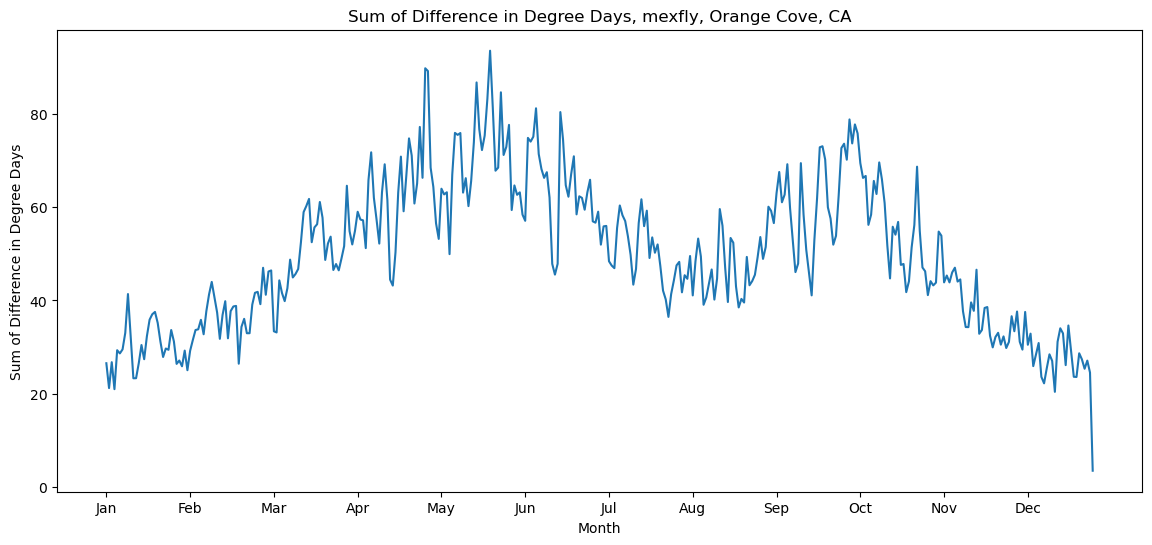

In [57]:
#in results df, make a new column for each year for the difference between model 1 degree days and each years degree days, Then sum all of the difference and plot 

for i in range(2000, 2024):
    results_df[f'{i}_diff'] = abs(results_df['degree_days'] - results_df[f'{i}'])
results_df['sum_diff'] = results_df.filter(like='_diff').sum(axis=1)
results_df
plt.figure(figsize=(14, 6))
plt.plot(results_df['sum_diff'])
plt.xticks(range(0, 366, 31), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.ylabel('Sum of Difference in Degree Days')
plt.title('Sum of Difference in Degree Days, mexfly, Orange Cove, CA')
plt.show()


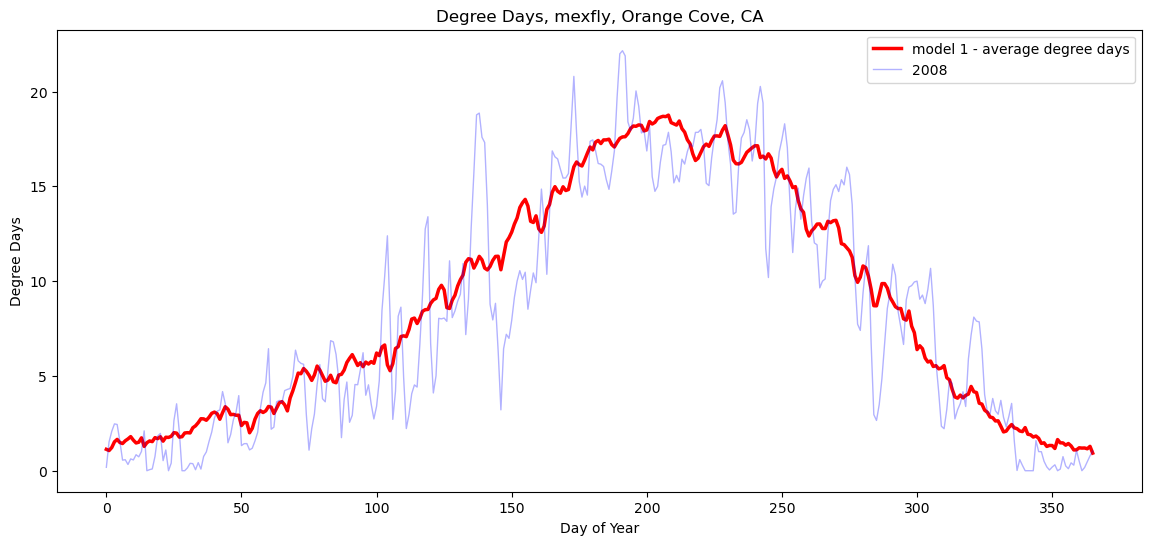

In [22]:
# Plot the results with month labels and the mod_1 average
import matplotlib.pyplot as plt

# Change plot size
plt.figure(figsize=(14, 6))

# Plot model 1 average degree days with a bold red line
plt.plot(results_df['degree_days'], color='red', linewidth=2.5, label='model 1 - average degree days')

# Plot model 2 results with thinner, semi-transparent lines in shades of blue
for i in range(2008,2009):
    plt.plot(results_df[f'{i}'], color='blue', alpha=0.3, linewidth=1, label=f'{i}')

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Day of Year')
plt.ylabel('Degree Days')
plt.title('Degree Days, mexfly, Orange Cove, CA')

# Show plot
plt.show()

In [42]:
#

,day_of_year,degree_days,date,2000,2001,2002,2003,2004,2005,2006,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,1,1.128148,01-01,0.987053,1.101892,3.784148,1.362793,0.817495,0.714278,2.163856,...,2.798467,0.000000,0.270382,0.000000,3.922774,0.200410,1.148149,0.098755,0.041450,2.820764
1,2,1.063439,01-02,0.531473,2.005266,3.090476,0.965644,0.915865,1.322307,0.852566,...,2.807354,0.486074,0.333230,0.109843,2.594909,0.094174,1.658027,1.473245,0.331305,0.775615
2,3,1.222878,01-03,0.000000,2.570675,3.612500,0.975612,0.770577,0.825402,1.890497,...,3.150565,0.420935,0.136008,0.082761,2.125063,0.611543,1.064936,1.932563,1.009862,0.106108
3,4,1.523498,01-04,0.602062,2.567037,1.846961,2.154172,0.010375,0.000000,1.645282,...,2.425877,0.589732,1.830597,1.438938,4.105460,1.438688,3.044777,2.253140,0.979605,2.011847
4,5,1.651103,01-05,0.912898,2.266758,0.507785,1.772629,0.026947,0.000000,2.565422,...,2.869898,0.678155,0.568848,2.203000,5.303500,2.412249,3.192137,3.022873,1.251583,3.923155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,362,1.193954,12-28,1.748261,1.179960,3.504055,0.181850,0.621956,3.281110,0.076974,...,0.755472,0.033679,0.481521,2.037326,0.085975,0.437368,2.644170,0.000384,1.094424,3.598253
362,363,1.199173,12-29,1.385457,2.424465,2.285221,0.149119,2.636427,2.239010,0.000000,...,0.689646,0.000000,0.612816,2.417486,0.426781,0.753578,2.291987,0.000000,1.610387,4.326422
363,364,1.157907,12-30,1.793121,2.651500,0.681140,0.724461,2.682650,0.057522,0.299958,...,0.503536,0.000000,0.914372,2.717687,0.571076,0.698882,1.580344,0.162206,0.422877,4.690927
364,365,1.285017,12-31,2.200561,2.836500,0.705584,2.647083,0.910659,1.528269,0.564601,...,0.000000,0.150341,1.981093,2.213251,0.788731,0.643144,1.264372,0.308399,3.342350,0.995648


In [6]:
combined_dd_data['day_of_year'] = combined_dd_data.indexes['t'].dayofyear
mod_1_data = combined_dd_data.groupby('day_of_year').mean('t')
mod_1_data_dd = mod_1_data['degree_days'].values

c:\Users\Thomas.Worm\AppData\Local\anaconda3\envs\fruitflypheno\Lib\site-packages\xarray\core\dataset.py:4802: UserWarning: No index created for dimension day_of_year because variable day_of_year is not a coordinate. To create an index for day_of_year, please first call `.set_coords('day_of_year')` on this object.
  warnings.warn(


In [12]:
combined_dd_data

<xarray.Dataset> Size: 181kB
Dimensions:      (point: 1, t: 9064)
Coordinates:
  * t            (t) datetime64[ns] 73kB 2000-01-01 2000-01-02 ... 2024-10-24
    longitude    float64 8B -119.3
    latitude     float64 8B 36.62
Dimensions without coordinates: point
Data variables:
    degree_days  (point, t) float64 73kB 0.9871 0.5315 0.0 ... 9.707 9.151 9.348
    day_of_year  (t) int32 36kB 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t

In [3]:
read_netcdfs

<function utils.processing_functions.read_netcdfs(files, dim, lat, lon, LTT, UTT)>